In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.nn.init as init
from torch.distributions import Categorical
import numpy as np
from tqdm import tqdm
import pandas as pd

from model.CustomDataSet import CustomDataSetRNN
from model.Tokenizer import SimpleTokenizerV1
from environnement.environnement1Str import Environnement1
from environnement.environnement3Str import Environnement3
from environnement.environnement6Str import Environnement6
from environnement.small_loop import small_loop
from environnement.gridWorld import gridWorld
from model.RNN import LSTM_Multi_Tasks
from inter.simpleInteraction import simpleInteraction as inter

from outil import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

The robot is in : 0  x: 1 y: 1
World : [[1 1 1 1 1 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 1 1 1 1 1]]
The robot is in : 0  x: 1 y: 1
World : [[1 1 1 1 1 1]
 [1 0 0 0 1 1]
 [1 0 1 0 0 1]
 [1 0 1 1 0 1]
 [1 0 0 0 0 1]
 [1 1 1 1 1 1]]


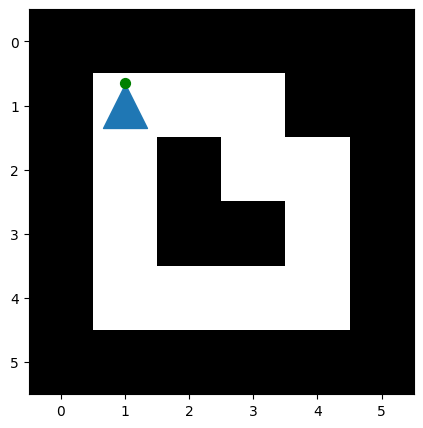

<pad>
('forward', 'wall')
('forward', 'empty')
('turn_left', 'empty')
('turn_right', 'empty')
('feel_front', 'wall')
('feel_front', 'empty')
('feel_left', 'wall')
('feel_left', 'empty')
('feel_right', 'wall')
('feel_right', 'empty')
{'<pad>': 0, ('forward', 'wall'): 1, ('forward', 'empty'): 2, ('turn_left', 'empty'): 3, ('turn_right', 'empty'): 4, ('feel_front', 'wall'): 5, ('feel_front', 'empty'): 6, ('feel_left', 'wall'): 7, ('feel_left', 'empty'): 8, ('feel_right', 'wall'): 9, ('feel_right', 'empty'): 10}
Data size :  1000
Data :  [1, 3, 1, 4, 5, 3, 9, 8, 3, 8, 8, 9, 9, 9, 3, 7, 4, 8, 6, 8, 8, 4, 4, 10, 4, 6, 10, 7, 2, 7, 6, 6, 4, 4, 4, 1, 10, 8, 8, 1, 3, 7, 2, 1, 4, 10, 5, 1, 7, 1, 4, 10, 3, 3, 9, 8, 5, 3, 9, 2, 6, 2, 7, 3, 10, 5, 1, 3, 7, 6, 7, 3, 4, 2, 2, 10, 1, 5, 3, 5, 5, 4, 3, 1, 9, 1, 8, 3, 3, 2, 4, 5, 10, 1, 5, 4, 9, 3, 4, 7, 6, 9, 7, 2, 5, 5, 5, 8, 3, 6, 3, 3, 4, 10, 4, 9, 6, 2, 6, 7, 6, 4, 5, 8, 10, 1, 10, 4, 3, 5, 10, 4, 6, 7, 6, 9, 2, 5, 10, 7, 7, 1, 5, 3, 3, 2, 6, 9, 2,

In [2]:
def get_data(env:env, tokenizer:SimpleTokenizerV1, n_episodes:int=1000):
    """
    Generate data from the environment.
    """
    data = []
    for _ in range(n_episodes):
        action = np.random.choice(env.get_actions())
        feedback = env.outcome(action)
        data.append(tokenizer.encode((action, feedback)))
    return data

env_test = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))
env_test = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 1, 1],
                [1, 0, 1, 0, 0, 1],
                [1, 0, 1, 1, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))
env_test.display_world()

list_vocab = ['<pad>']
# Nous notons toutes les interactions techniquement possible
for act in env_test.get_actions():
    for fb in env_test.get_outcomes():
        list_vocab.append((act, fb))

# Nous pouvons suprimer des interactions qui ne sont en réalité pas possible.
list_vocab.remove(('turn_left', 'wall'))
list_vocab.remove(('turn_right', 'wall'))
for element in list_vocab:
    print(element)
    
tmp = create_dico_numerate_word(list_vocab)
print(tmp)
tokenizer = SimpleTokenizerV1(vocab=tmp)

data = get_data(env_test, tokenizer, n_episodes=1000)

data_test = get_data(env_test, tokenizer, n_episodes=10000)
print("Data size : ", len(data))
print("Data : ", data)

dict_tasks = {
    tokenizer.encode(('forward', 'wall')): {'task' : 0,  'goal': 0},
    tokenizer.encode(('forward', 'empty')): {'task': 0, 'goal': 1},
    tokenizer.encode(('turn_left', 'empty')): {'task': 1, 'goal': 1},
    tokenizer.encode(('turn_right', 'empty')): {'task': 2, 'goal': 1},
    tokenizer.encode(('feel_front', 'wall')): {'task': 3, 'goal': 0},
    tokenizer.encode(('feel_front', 'empty')): {'task': 3, 'goal': 1},
    tokenizer.encode(('feel_left', 'wall')): {'task': 4, 'goal': 0},
    tokenizer.encode(('feel_left', 'empty')): {'task': 4, 'goal': 1},
    tokenizer.encode(('feel_right', 'wall')): {'task': 5, 'goal': 0},
    tokenizer.encode(('feel_right', 'empty')): {'task': 5, 'goal': 1},
}

In [3]:
class CustomDataSetTextGenByToken(Dataset):
    def __init__(self, token, context_lenght:int, dict_tasks:dict, id_pad:int=0, min:int = 1, sride:int = 1):
        """
        Creates a custom dataset
        """
        # assert context_lenght % 2 != 0, "context_lenght must be odd"
        # assert len(actions) == len(outcomes), "actions and outcomes must have the same length"
        assert context_lenght > 0, "context_lenght can't be negative or zero"

        self.context_lenght = context_lenght
        self.tokenizer = tokenizer
        self.dim_out = tokenizer.size_vocab
        self.token = token
        self.padding = id_pad
        self.min = min
        self.sride = sride
        self.dict_tasks = dict_tasks
        self.data = self.create_data()

    # Fonction vue précédament
    def create_data(self):
        """
        Create the data
        """
        sentences = []
        for range_cut in range(self.min, self.context_lenght + 1, 1):
            for i in range(0, len(self.token) - range_cut,  self.sride):
                sequence = self.token[i:i + range_cut]
                sentences.append(
                    (
                        torch.tensor(sequence[:-1]),#  + [self.padding] * (self.context_lenght - len(self.token[i:i + range_cut]))),
                        torch.tensor(self.dict_tasks[sequence[-1]]['goal']),
                        self.dict_tasks[sequence[-1]]['task']
                    )
                )
        return sentences

    def __len__(self):
        """
        Get the length of the dataset
        :return: length
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Get the item at the index idx

        :param idx: index
        :return: x
        """
        return self.data[idx]

In [4]:
data_set = CustomDataSetTextGenByToken(
    token=data,
    dict_tasks=dict_tasks,
    id_pad=tokenizer.encode("<pad>"),
    context_lenght=10,
    min=10)

data_test = CustomDataSetTextGenByToken(
    token=data_test,
    dict_tasks=dict_tasks,
    id_pad=tokenizer.encode("<pad>"),
    context_lenght=10,
    min=10)

print(f"\033[0;32mLe data set\033[0m")
for i in data_set:
    print(i)
print(f"\033[0;32mTaille du data set {data_set.__len__()}\033[0m")

Le data set
(tensor([1, 3, 1, 4, 5, 3, 9, 8, 3]), tensor(1), 4)
(tensor([3, 1, 4, 5, 3, 9, 8, 3, 8]), tensor(1), 4)
(tensor([1, 4, 5, 3, 9, 8, 3, 8, 8]), tensor(0), 5)
(tensor([4, 5, 3, 9, 8, 3, 8, 8, 9]), tensor(0), 5)
(tensor([5, 3, 9, 8, 3, 8, 8, 9, 9]), tensor(0), 5)
(tensor([3, 9, 8, 3, 8, 8, 9, 9, 9]), tensor(1), 1)
(tensor([9, 8, 3, 8, 8, 9, 9, 9, 3]), tensor(0), 4)
(tensor([8, 3, 8, 8, 9, 9, 9, 3, 7]), tensor(1), 2)
(tensor([3, 8, 8, 9, 9, 9, 3, 7, 4]), tensor(1), 4)
(tensor([8, 8, 9, 9, 9, 3, 7, 4, 8]), tensor(1), 3)
(tensor([8, 9, 9, 9, 3, 7, 4, 8, 6]), tensor(1), 4)
(tensor([9, 9, 9, 3, 7, 4, 8, 6, 8]), tensor(1), 4)
(tensor([9, 9, 3, 7, 4, 8, 6, 8, 8]), tensor(1), 2)
(tensor([9, 3, 7, 4, 8, 6, 8, 8, 4]), tensor(1), 2)
(tensor([3, 7, 4, 8, 6, 8, 8, 4, 4]), tensor(1), 5)
(tensor([ 7,  4,  8,  6,  8,  8,  4,  4, 10]), tensor(1), 2)
(tensor([ 4,  8,  6,  8,  8,  4,  4, 10,  4]), tensor(1), 3)
(tensor([ 8,  6,  8,  8,  4,  4, 10,  4,  6]), tensor(1), 5)
(tensor([ 6,  8,  8,  4, 

In [5]:
class LSTM_Multi_Tasks(nn.Module):
    def __init__(self, num_emb, output_size, tasks:int, num_layers=1, hidden_size=128, dropout=0.5):
        super(LSTM_Multi_Tasks, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.num_emb = num_emb
        self.output_size = output_size

        # Create an embedding layer to convert token indices to dense vectors
        self.embedding = nn.Embedding(num_emb, hidden_size)
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, 
                            num_layers=num_layers, batch_first=True, dropout=dropout)
        
        self.linear_share = nn.Linear(hidden_size, hidden_size // 2)
        
        for i in range(tasks):
            setattr(self, f'fc_out_{i}', nn.Sequential(
                nn.Linear(hidden_size // 2, hidden_size // 4),
                nn.Linear(hidden_size // 4, output_size),
            ))


    def forward(self, input_seq, hidden_in, mem_in, task:int):
        """
        Forward pass of the LSTM model.
        This method takes an input sequence, hidden state, and memory state,
        and returns the output of the LSTM model for a specific task.
        
        Args:
            input_seq (_type_): _input sequence of shape (batch_size, seq_len)_
            hidden_in (_type_): _initial hidden state of shape (num_layers, batch_size, hidden_size)_
            mem_in (_type_): _initial memory state of shape (num_layers, batch_size, hidden_size)_
            task (int): _task index to select the output layer_
            
        Returns:
            _type_: _output of the LSTM model for the specified task_
        """
        # Convert token indices to dense vectors
        input_embs = self.embedding(input_seq)

        # Pass the embeddings through the LSTM layer
        output, (hidden_out, mem_out) = self.lstm(input_embs, (hidden_in, mem_in))
        
        output = self.linear_share(output)
        # Reshape the output to match the expected input shape for the fully connected layer
        # output = output.view(-1, self.hidden_size // 2)
        # Pass the output through the linear layer to get the final output

        # Pass the LSTM output through the fully connected layer to get the final output
        fc_out = getattr(self, f'fc_out_{task}')
        return fc_out(output), hidden_out, mem_out


In [6]:
class TokenDrop(nn.Module):
    """For a batch of tokens indices, randomly replace a non-specical token with <pad>.
    
    Args:
        prob (float): probability of dropping a token
        pad_token (int): index for the <pad> token
        num_special (int): Number of special tokens, assumed to be at the start of the vocab
    """

    def __init__(self, prob=0.1, pad_token=0, num_special=4):
        self.prob = prob
        self.num_special = num_special
        self.pad_token = pad_token

    def __call__(self, sample):
        mask = torch.bernoulli(self.prob * torch.ones_like(sample)).long()
        
        can_drop = (sample >= self.num_special).long()
        mask = mask * can_drop
        
        replace_with = (self.pad_token * torch.ones_like(sample)).long()
        
        sample_out = (1 - mask) * sample + mask * replace_with
        
        return sample_out

In [7]:
def train(model, train_loader, optimizer, loss_fn:dict, num_epochs=10, td:TokenDrop|None=None):
    """
    Train the model on the training data.
    """
    
    model.train()
    total_loss = 0
    loss = None
    for epoch in tqdm(range(num_epochs), desc= f'loss : {loss.item() if loss is not None else "nan"}'):
        total_loss = 0
        training_loss = []
        epoch_loss = []
        loss_dict = {}
        for i in range(len(loss_fn)):
            loss_dict[i] = []
        for (x, y, task) in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} loss : {loss.item() if loss is not None else 'nan'}"):
            task = task.tolist()
            task = task[0] if len(task) == 1 else task
            # x, y, task
            if td is not None:
                x = td(x[:,:])
            x = x.to(device)
            y = y.to(device)
            bs = y.shape[0]
            
            h = torch.zeros(model.num_layers, bs, model.hidden_size, device=device)
            cell = torch.zeros(model.num_layers, bs, model.hidden_size, device=device)
            
            # Forward pass
            output, h, cell = model(x, h, cell, task)
            
            # print(f'Pour la séquence {x}')
            # print(tokenizer.decode(x[0].tolist()))
            # print(f'Pour la tâche {task}, la sortie est {output}')
            # print(f'Pour la tâche {task}, la sortie est {output[:, -1, :]}')
            # print(f'Pour la tâche {task}, la cible est {y}')
            loss = loss_fn[task](output[:, -1, :], y)
            training_loss.append(loss.item())
            loss_dict[task].append(loss.item())
            # print(f"prediction : {output[:, -1, :]}")
            # print(f"target : {y}")
            # print(f"Task {task} Loss: {loss.item()}")
            total_loss += loss.item()
            # if loss.item() <= 0.0000000000000001:
            #     break
            
            optimizer.zero_grad()
            if task in [0, 1, 2, 3, 4, 5]:
                loss.backward()
            optimizer.step()
            # Clip gradients to prevent exploding gradients
            # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        epoch_loss.append(total_loss)
        if loss.item() <= 0.00000000000000001:
                break
        # print(len(train_loader))
        # print(total_loss)
        # print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}")
    return training_loss, loss_dict, epoch_loss

In [8]:
lstm_multitask = LSTM_Multi_Tasks(
    hidden_size= 32,
    num_layers=1,
    num_emb=tokenizer.size_vocab,
    tasks=6, # number of tasks
    output_size=2, # empty or wall
    dropout=0.1
).to(device)

dict_loss = {}
for i in range(6):
    dict_loss[i] = nn.CrossEntropyLoss().to(device)
# Optimizer
optimizer = optim.Adam(lstm_multitask.parameters(), lr=0.001)
print('size data set : ', len(data_set))
data_load = DataLoader(data_set, batch_size=1, shuffle=True)

td = TokenDrop(prob=0.3, pad_token=tokenizer.encode("<pad>"), num_special=1)

/home/pe/Documents/stage/Dpt_transformers/.venv/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


size data set :  990


loss : nan: 100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


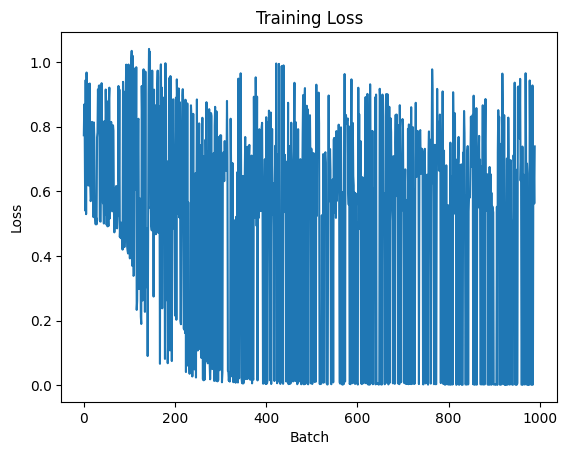

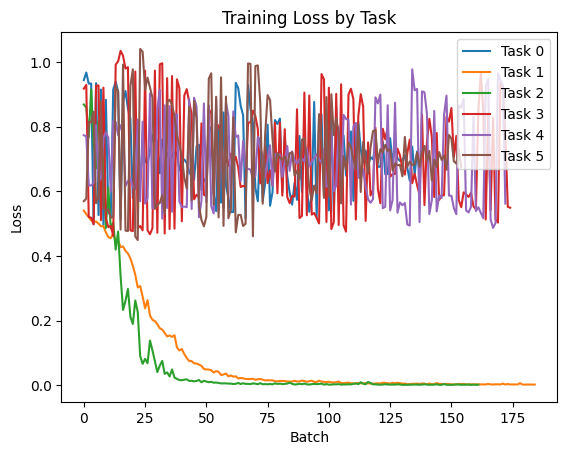

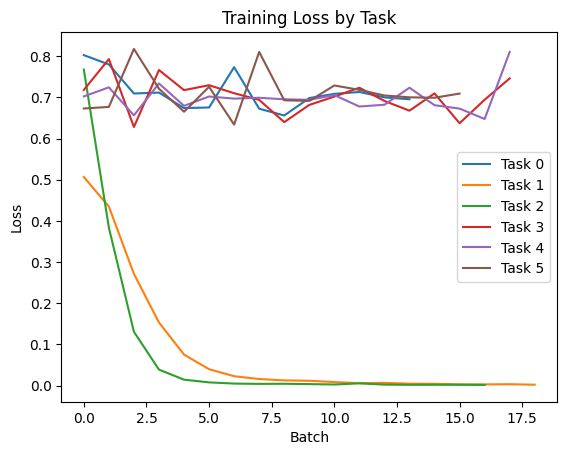

In [9]:
training_loss, dict_ , _ = train(
    model=lstm_multitask,
    train_loader=data_load,
    optimizer=optimizer,
    loss_fn=dict_loss,
    num_epochs=1,
    td=td
)

# display loss
plt.plot(training_loss)
plt.title("Training Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()

for i in range(6):
    plt.plot(dict_[i], label=f"Task {i}")
plt.title("Training Loss by Task")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# windows means
windows_means = {
    0 : [],
    1 : [],
    2 : [],
    3 : [],
    4 : [],
    5 : []
}

window_size = 10
for j in range(6):
    for i in range(0, len(dict_[j]), window_size):
        windows_means[j].append(np.mean(dict_[j][i:i + window_size]))
        
for i in range(6):
    plt.plot(windows_means[i], label=f"Task {i}")
plt.title("Training Loss by Task")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.legend()
plt.show()



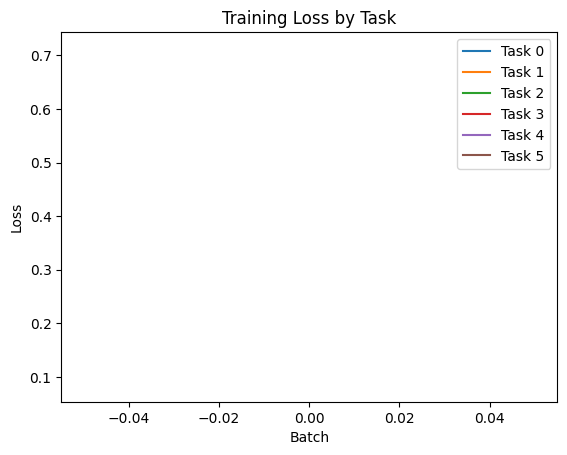

In [10]:
windows_means = {
    0 : [],
    1 : [],
    2 : [],
    3 : [],
    4 : [],
    5 : []
}
window_size = 200
for j in range(6):
    for i in range(0, len(dict_[j]), window_size):
        windows_means[j].append(np.mean(dict_[j][i:i + window_size]))
        
for i in range(6):
    plt.plot(windows_means[i], label=f"Task {i}")
plt.title("Training Loss by Task")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [11]:
env_test_manu = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))

action = []
outcome = []
interaction = []
list_act_to_make = ['feel_front', 'feel_front', 'feel_front', 'feel_front', 'feel_front', 'feel_front', 'feel_left', 'feel_right', 'turn_right', 'turn_right']
for act in list_act_to_make:
    action.append(act)
    outcome.append(env_test_manu.outcome(action[-1]))
    interaction.append(tokenizer.encode((action[-1], outcome[-1])))
    env_test_manu.save_world(path='imgToGif')
# for i in range(5):
#     action.append(str(np.random.choice(env_test_manu.get_actions())))
#     outcome.append(env_test_manu.outcome(action[-1]))
#     interaction.append(tokenizer.encode((action[-1], outcome[-1])))
#     env_test_manu.save_world(path='imgToGif')

print("Action : ", action)
print("Outcome : ", outcome)
print("Interaction : ", interaction)


data_test_one = torch.tensor(interaction).to(device)
data_test_one = data_test_one.unsqueeze(0)
lstm_multitask.eval()

hidden = torch.zeros(lstm_multitask.num_layers, 1, lstm_multitask.hidden_size, device=device)
memory = torch.zeros(lstm_multitask.num_layers, 1, lstm_multitask.hidden_size, device=device)

pred, h0, m0 = lstm_multitask(data_test_one, hidden, memory, task=0)
proba = F.softmax(pred[:, -1, :], dim=1)
print(f'for task forward : {pred[:, -1, :]} proba {proba}')
pred, h1, m1 = lstm_multitask(data_test_one, hidden, memory, task=1)
proba = F.softmax(pred[:, -1, :], dim=1)
print(f'for task turn left : {pred[:, -1, :]} proba {proba}')
pred, h2, m2 = lstm_multitask(data_test_one, hidden, memory, task=2)
proba = F.softmax(pred[:, -1, :], dim=1)
print(f'for task turn right : {pred[:, -1, :]} proba {proba}')
pred, h3, m3 = lstm_multitask(data_test_one, hidden, memory, task=3)
proba = F.softmax(pred[:, -1, :], dim=1)
print(f'for task feel front : {pred[:, -1, :]} proba {proba}')
pred, h4, m4 = lstm_multitask(data_test_one, hidden, memory, task=4)
proba = F.softmax(pred[:, -1, :], dim=1)
print(f'for task feel left : {pred[:, -1, :]} proba {proba}')
pred, h5, m5 = lstm_multitask(data_test_one, hidden, memory, task=5)
proba = F.softmax(pred[:, -1, :], dim=1)
print(f'for task feel right : {pred[:, -1, :]} proba {proba}')


print(h0)
print(h1)

The robot is in : 0  x: 1 y: 1
World : [[1 1 1 1 1 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 1 1 1 1 1]]
Action :  ['feel_front', 'feel_front', 'feel_front', 'feel_front', 'feel_front', 'feel_front', 'feel_left', 'feel_right', 'turn_right', 'turn_right']
Outcome :  ['wall', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 'empty', 'empty', 'empty']
Interaction :  [5, 5, 5, 5, 5, 5, 7, 10, 4, 4]
for task forward : tensor([[0.6989, 0.7502]], device='cuda:0', grad_fn=<SliceBackward0>) proba tensor([[0.4872, 0.5128]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
for task turn left : tensor([[-3.5754,  2.4859]], device='cuda:0', grad_fn=<SliceBackward0>) proba tensor([[0.0023, 0.9977]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
for task turn right : tensor([[-4.6962,  1.9180]], device='cuda:0', grad_fn=<SliceBackward0>) proba tensor([[0.0013, 0.9987]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
for task feel front : tensor([[ 0.2292, -0.1033]], device='cuda:0', 

In [12]:
env_test_manu = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))

action = []
outcome = []
interaction = []
list_act_to_make = ['turn_left', 'turn_right', 'feel_front', 'feel_left', 'feel_right',]
for act in list_act_to_make:
    action.append(act)
    outcome.append(env_test_manu.outcome(action[-1]))
    interaction.append(tokenizer.encode((action[-1], outcome[-1])))
    env_test_manu.save_world(path='imgToGif')
# for i in range(5):
#     action.append(str(np.random.choice(env_test_manu.get_actions())))
#     outcome.append(env_test_manu.outcome(action[-1]))
#     interaction.append(tokenizer.encode((action[-1], outcome[-1])))
#     env_test_manu.save_world(path='imgToGif')

print("Action : ", action)
print("Outcome : ", outcome)
print("Interaction : ", interaction)


data_test_one = torch.tensor(interaction).to(device)
data_test_one = data_test_one.unsqueeze(0)
lstm_multitask.eval()

hidden = torch.zeros(lstm_multitask.num_layers, 1, lstm_multitask.hidden_size, device=device)
memory = torch.zeros(lstm_multitask.num_layers, 1, lstm_multitask.hidden_size, device=device)

pred, h0, m0 = lstm_multitask(data_test_one, hidden, memory, task=0)
proba = F.softmax(pred[:, -1, :], dim=1)
print(f'for task forward : {pred[:, -1, :]} proba {proba}')
pred, h1, m1 = lstm_multitask(data_test_one, hidden, memory, task=1)
proba = F.softmax(pred[:, -1, :], dim=1)
print(f'for task turn left : {pred[:, -1, :]} proba {proba}')
pred, h2, m2 = lstm_multitask(data_test_one, hidden, memory, task=2)
proba = F.softmax(pred[:, -1, :], dim=1)
print(f'for task turn right : {pred[:, -1, :]} proba {proba}')
pred, h3, m3 = lstm_multitask(data_test_one, hidden, memory, task=3)
proba = F.softmax(pred[:, -1, :], dim=1)
print(f'for task feel front : {pred[:, -1, :]} proba {proba}')
pred, h4, m4 = lstm_multitask(data_test_one, hidden, memory, task=4)
proba = F.softmax(pred[:, -1, :], dim=1)
print(f'for task feel left : {pred[:, -1, :]} proba {proba}')
pred, h5, m5 = lstm_multitask(data_test_one, hidden, memory, task=5)
proba = F.softmax(pred[:, -1, :], dim=1)
print(f'for task feel right : {pred[:, -1, :]} proba {proba}')


print(h0)
print(h1)

The robot is in : 0  x: 1 y: 1
World : [[1 1 1 1 1 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 1 1 1 1 1]]
Action :  ['turn_left', 'turn_right', 'feel_front', 'feel_left', 'feel_right']
Outcome :  ['empty', 'empty', 'wall', 'wall', 'empty']
Interaction :  [3, 4, 5, 7, 10]
for task forward : tensor([[0.5869, 0.5073]], device='cuda:0', grad_fn=<SliceBackward0>) proba tensor([[0.5199, 0.4801]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
for task turn left : tensor([[-3.0295,  2.1195]], device='cuda:0', grad_fn=<SliceBackward0>) proba tensor([[0.0058, 0.9942]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
for task turn right : tensor([[-3.7564,  1.5101]], device='cuda:0', grad_fn=<SliceBackward0>) proba tensor([[0.0051, 0.9949]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
for task feel front : tensor([[ 0.1357, -0.1541]], device='cuda:0', grad_fn=<SliceBackward0>) proba tensor([[0.5719, 0.4281]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
for task feel left : t

In [13]:
data_test_one = torch.tensor([
    tokenizer.encode(("forward", "empty")), tokenizer.encode(("turn_left", "empty")),
    tokenizer.encode(("turn_right", "empty")), tokenizer.encode(("feel_front", "empty")),
    tokenizer.encode(("feel_left", "wall")), tokenizer.encode(("feel_right", "wall")),
    tokenizer.encode(("turn_right", "empty")), tokenizer.encode(("feel_front", "wall")),
    tokenizer.encode(("turn_right", "empty")), tokenizer.encode(("turn_right", "empty")),
], device=device)

data_test_one = data_test_one.view(1, -1)
lstm_multitask.eval()

hidden = torch.zeros(lstm_multitask.num_layers, 1, lstm_multitask.hidden_size, device=device)
memory = torch.zeros(lstm_multitask.num_layers, 1, lstm_multitask.hidden_size, device=device)

pred, _, _ = lstm_multitask(data_test_one, hidden, memory, task=0)
print(f'for task 0 : {pred[:, -1, :]}')
pred, _, _ = lstm_multitask(data_test_one, hidden, memory, task=1)
print(f'for task 1 : {pred[:, -1, :]}')
pred, _, _ = lstm_multitask(data_test_one, hidden, memory, task=2)
print(f'for task 2 : {pred[:, -1, :]}')
pred, _, _ = lstm_multitask(data_test_one, hidden, memory, task=3)
print(f'for task 3 : {pred[:, -1, :]}')
pred, _, _ = lstm_multitask(data_test_one, hidden, memory, task=4)
print(f'for task 4 : {pred[:, -1, :]}')
pred, _, _ = lstm_multitask(data_test_one, hidden, memory, task=5)
print(f'for task 5 : {pred[:, -1, :]}')

env_test_manu = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))
env_test_manu.outcome("forward")
env_test_manu.save_world(path="imgToGif")


for task 0 : tensor([[0.7028, 0.7489]], device='cuda:0', grad_fn=<SliceBackward0>)
for task 1 : tensor([[-3.5801,  2.4895]], device='cuda:0', grad_fn=<SliceBackward0>)
for task 2 : tensor([[-4.7052,  1.9237]], device='cuda:0', grad_fn=<SliceBackward0>)
for task 3 : tensor([[ 0.2312, -0.1065]], device='cuda:0', grad_fn=<SliceBackward0>)
for task 4 : tensor([[-0.2463, -0.6639]], device='cuda:0', grad_fn=<SliceBackward0>)
for task 5 : tensor([[-0.0318,  0.1205]], device='cuda:0', grad_fn=<SliceBackward0>)
The robot is in : 0  x: 1 y: 1
World : [[1 1 1 1 1 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 1 1 1 1 1]]


(tensor([5, 1, 7, 7, 1, 7, 3, 4, 1]), tensor(0), 3)
(tensor([1, 7, 7, 1, 7, 3, 4, 1, 5]), tensor(0), 3)
(tensor([7, 7, 1, 7, 3, 4, 1, 5, 5]), tensor(0), 4)
(tensor([7, 1, 7, 3, 4, 1, 5, 5, 7]), tensor(0), 0)
(tensor([1, 7, 3, 4, 1, 5, 5, 7, 1]), tensor(1), 5)

In [14]:
# Test the model
lstm_multitask.eval()

data_test_loader = DataLoader(data_test, batch_size=1, shuffle=False)
acc = 0

dic_acc = {
    0 : [],
    1 : [],
    2 : [],
    3 : [],
    4 : [],
    5 : []
}

with torch.no_grad():
    for (x, y, task) in data_test_loader:
        task = task.tolist()
        task = task[0] if len(task) == 1 else task
        x = x.to(device)
        y = y.to(device)
        
        h = torch.zeros(lstm_multitask.num_layers, 1, lstm_multitask.hidden_size, device=device)
        cell = torch.zeros(lstm_multitask.num_layers, 1, lstm_multitask.hidden_size, device=device)
        
        # Forward pass
        output, h, cell = lstm_multitask(x, h, cell, task)
        
        # Get the predicted action
        _, predicted = torch.max(output[:, -1, :], 1)
        acc += (predicted == y).sum().item()
        dic_acc[task].append((predicted == y).sum().item())
        if (predicted == y).sum().item() == 0:
            print(f"Task: {task}")
            print(f"Input: {tokenizer.decode(x.tolist()[0])}")
            print(f"Predicted: {predicted}, Target: {y}")
            proba = F.softmax(output[:, -1, :], dim=1)
            print(f"Probabilities: {proba}")
            
            # Uncomment the following lines to see the predicted and target actions
            # for i in range(len(predicted)):
            #     print(f"Predicted: {tokenizer.decode(predicted[i].tolist())}, Target: {tokenizer.decode(y[i].tolist())}")

        # Print the predicted and target actions
        # print(f"Input: {tokenizer.decode(x.tolist()[0])}")
        # print(f"Predicted: {predicted}, Target: {y}")
        # print(f"Task: {task}")
        
print(f"Accuracy: {acc / len(data_test_loader)}")


Task: 4
Input: [('feel_front', 'wall'), ('turn_left', 'empty'), ('feel_front', 'empty'), ('feel_left', 'empty'), ('forward', 'empty'), ('feel_left', 'wall'), ('feel_front', 'empty'), ('turn_left', 'empty'), ('feel_right', 'empty')]
Predicted: tensor([0], device='cuda:0'), Target: tensor([1], device='cuda:0')
Probabilities: tensor([[0.6084, 0.3916]], device='cuda:0')
Task: 0
Input: [('turn_left', 'empty'), ('feel_front', 'empty'), ('feel_left', 'empty'), ('forward', 'empty'), ('feel_left', 'wall'), ('feel_front', 'empty'), ('turn_left', 'empty'), ('feel_right', 'empty'), ('feel_left', 'empty')]
Predicted: tensor([1], device='cuda:0'), Target: tensor([0], device='cuda:0')
Probabilities: tensor([[0.4886, 0.5114]], device='cuda:0')
Task: 3
Input: [('forward', 'empty'), ('feel_left', 'wall'), ('feel_front', 'empty'), ('turn_left', 'empty'), ('feel_right', 'empty'), ('feel_left', 'empty'), ('forward', 'wall'), ('turn_right', 'empty'), ('feel_left', 'wall')]
Predicted: tensor([0], device='cud

In [15]:
env_test_other = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 1, 1],
                [1, 0, 1, 0, 0, 1],
                [1, 0, 1, 1, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))
data_test_other_env = get_data(env_test_other, tokenizer, 10000)

lstm_multitask.eval()

data_set_other = CustomDataSetTextGenByToken(
    token=data_test_other_env,
    dict_tasks=dict_tasks,
    id_pad=tokenizer.encode("<pad>"),
    context_lenght=10,
    min=10)

data_test_loader_other = DataLoader(data_set_other, batch_size=1, shuffle=False)
acc = 0

with torch.no_grad():
    for (x, y, task) in data_test_loader_other:
        task = task.tolist()
        task = task[0] if len(task) == 1 else task
        x = x.to(device)
        y = y.to(device)
        
        h = torch.zeros(lstm_multitask.num_layers, 1, lstm_multitask.hidden_size, device=device)
        cell = torch.zeros(lstm_multitask.num_layers, 1, lstm_multitask.hidden_size, device=device)
        
        # Forward pass
        output, h, cell = lstm_multitask(x, h, cell, task)
        
        # Get the predicted action
        _, predicted = torch.max(output[:, -1, :], 1)
        acc += (predicted == y).sum().item()
        # Print the predicted and target actions
        # print(f"Input: {tokenizer.decode(x.tolist()[0])}")
        # print(f"Predicted: {predicted}, Target: {y}")
        # print(f"Task: {task}")
        
print(f"Accuracy: {acc / len(data_test_loader_other)}")


The robot is in : 0  x: 1 y: 1
World : [[1 1 1 1 1 1]
 [1 0 0 0 1 1]
 [1 0 1 0 0 1]
 [1 0 1 1 0 1]
 [1 0 0 0 0 1]
 [1 1 1 1 1 1]]
Accuracy: 0.7294294294294295


In [16]:
def encode_list_interaction(list_interaction:list, tokenizer:SimpleTokenizerV1|None=None):
    """
    pass [1, 2, 3] to 123
    """
    if type(list_interaction[0]) is not int:
        if tokenizer is None:
            assert False, "tokenizer is None and list is not number, please pass a tokenizer or list of number"
        list_interaction = tokenizer.encode(list_interaction)
        
    return int("".join(map(str, list_interaction)))

def decode_int_interaction(number:int, tokenizer:SimpleTokenizerV1|None=None):
    """
    pass 123 to [1, 2, 3]
    """
    if tokenizer is None:
        return [int(i) for i in str(number)]
    else:
        return tokenizer.decode([int(i) for i in str(number)])

In [17]:
print(encode_list_interaction([1, 2, 3]))
print(encode_list_interaction([('forward', 'wall'), ('forward', 'empty'), ('turn_left', 'empty')], tokenizer))
print(decode_int_interaction(123))
print(decode_int_interaction(123, tokenizer))

123
123
[1, 2, 3]
[('forward', 'wall'), ('forward', 'empty'), ('turn_left', 'empty')]


In [18]:
def make_data(data:dict, seq:list, list_interaction:list, max_lenght:int|None, tokenizer:SimpleTokenizerV1|None=None):
    """
    Create a dataset from the data.
    """
    if max_lenght is None:
        max_lenght = len(seq)
    else:
        max_lenght = min(len(seq), max_lenght)
    interaction_to_add = seq[-1]
    for i in range(2, max_lenght + 1):
        seq_to_add = seq[-i:-1]
        encode_seq_to_add = encode_list_interaction(seq_to_add, tokenizer)
        if encode_seq_to_add not in data:
            data[encode_seq_to_add] = {}
        if interaction_to_add not in data[encode_seq_to_add]:
            data[encode_seq_to_add][interaction_to_add] = 0
        print(data)
        data[encode_seq_to_add][interaction_to_add] += 1
        
    return data

In [41]:
seq_to_test = tokenizer.encode([
    ('forward', 'wall')
])
data = {}
list_interaction = []
for act in env_test.get_actions():
    for fb in env_test.get_outcomes():
        list_interaction.append((act, fb))
list_interaction.remove(('turn_left', 'wall'))
list_interaction.remove(('turn_right', 'wall'))

data = make_data(data, seq_to_test, list_interaction, max_lenght=None, tokenizer=tokenizer)
print(data)

{}


In [47]:
seq_to_test = tokenizer.encode([
    ('forward', 'wall'), ('forward', 'wall'), ('forward', 'empty'), ('forward', 'wall'), ('forward', 'wall'), ('turn_left', 'empty')
])
new_data = make_data(data, seq_to_test, list_interaction, max_lenght=None, tokenizer=tokenizer)
print(new_data)

for key, value in new_data.items():
    print(f"key: {tokenizer.decode(decode_int_interaction(key))}")
    for k, v in value.items():
        print(f"   inter: {tokenizer.decode(k)} ({k}) value: {v}")
    

{1: {1: 2, 2: 1, 3: 0}, 11: {2: 1}, 2: {1: 1}, 12: {1: 1}, 112: {1: 1}, 21: {1: 1}, 121: {1: 1}, 1121: {1: 1}}
{1: {1: 2, 2: 1, 3: 1}, 11: {2: 1, 3: 0}, 2: {1: 1}, 12: {1: 1}, 112: {1: 1}, 21: {1: 1}, 121: {1: 1}, 1121: {1: 1}}
{1: {1: 2, 2: 1, 3: 1}, 11: {2: 1, 3: 1}, 2: {1: 1}, 12: {1: 1}, 112: {1: 1}, 21: {1: 1}, 121: {1: 1}, 1121: {1: 1}, 211: {3: 0}}
{1: {1: 2, 2: 1, 3: 1}, 11: {2: 1, 3: 1}, 2: {1: 1}, 12: {1: 1}, 112: {1: 1}, 21: {1: 1}, 121: {1: 1}, 1121: {1: 1}, 211: {3: 1}, 1211: {3: 0}}
{1: {1: 2, 2: 1, 3: 1}, 11: {2: 1, 3: 1}, 2: {1: 1}, 12: {1: 1}, 112: {1: 1}, 21: {1: 1}, 121: {1: 1}, 1121: {1: 1}, 211: {3: 1}, 1211: {3: 1}, 11211: {3: 0}}
{1: {1: 2, 2: 1, 3: 1}, 11: {2: 1, 3: 1}, 2: {1: 1}, 12: {1: 1}, 112: {1: 1}, 21: {1: 1}, 121: {1: 1}, 1121: {1: 1}, 211: {3: 1}, 1211: {3: 1}, 11211: {3: 1}}
key: [('forward', 'wall')]
   inter: ('forward', 'wall') (1) value: 2
   inter: ('forward', 'empty') (2) value: 1
   inter: ('turn_left', 'empty') (3) value: 1
key: [('forward', 'w

In [ ]:
# def make_data_set(data:dict, dict_tasks:dict, tokenizer:SimpleTokenizerV1|None=None):
#     """
#     """
#     data_set = []
#     for seq, interactions in data.items():
        
#         data_len_for_tasks = {}
#         for inter_, count in interactions.items():
#             number_of_task = dict_tasks[inter_] ['task']
#             if number_of_task not in data_len_for_tasks:
#                 data_len_for_tasks[number_of_task] = 0
#             data_len_for_tasks[number_of_task] += count
            
#         print(data_len_for_tasks)
#         all_target = []
#         for task in data_len_for_tasks.keys():

#             tmp = [interaction for interaction, valeur in dict_tasks.items() if valeur["task"] == task]
#             one_target = []
#             for tmp_ in tmp:
#                 if tmp_ not in interactions:
#                     one_target.append(0)
#                 else:
#                     one_target.append(round(interactions[tmp_] / data_len_for_tasks[task], 5))
#             all_target.append(one_target)
#         print(all_target)
#         data_set.append((decode_int_interaction(seq), all_target, list(data_len_for_tasks.keys())))
            
#     return data_set

def make_data_set(data:dict, dict_tasks:dict, tokenizer:SimpleTokenizerV1|None=None):
    data_set = []

    for seq, interactions in data.items():
        # Calculer la longueur des données pour chaque tâche
        data_len_for_tasks = {
            dict_tasks[inter_]['task']: sum(count for inter, count in interactions.items() if dict_tasks[inter]['task'] == dict_tasks[inter_]['task'])
            for inter_ in interactions
        }
        
        all_target = [
            [
                round(interactions.get(interaction, 0) / data_len_for_tasks[task], 5)
                for interaction in dict_tasks if dict_tasks[interaction]['task'] == task
            ]
            for task in data_len_for_tasks
        ]

        data_set.append((decode_int_interaction(seq), all_target, list(data_len_for_tasks.keys())))

    return data_set

In [ ]:
dict_tasks = {
    tokenizer.encode(('forward', 'wall')): {'task' : 0,  'goal': 0},
    tokenizer.encode(('forward', 'empty')): {'task': 0, 'goal': 1},
    tokenizer.encode(('turn_left', 'empty')): {'task': 1, 'goal': 1},
    tokenizer.encode(('turn_right', 'empty')): {'task': 2, 'goal': 1},
    tokenizer.encode(('feel_front', 'wall')): {'task': 3, 'goal': 0},
    tokenizer.encode(('feel_front', 'empty')): {'task': 3, 'goal': 1},
    tokenizer.encode(('feel_left', 'wall')): {'task': 4, 'goal': 0},
    tokenizer.encode(('feel_left', 'empty')): {'task': 4, 'goal': 1},
    tokenizer.encode(('feel_right', 'wall')): {'task': 5, 'goal': 0},
    tokenizer.encode(('feel_right', 'empty')): {'task': 5, 'goal': 1},
}
res = make_data_set(new_data, dict_tasks, tokenizer)
print(res)


{0: 3, 1: 1}
[[0.66667, 0.33333], [1.0]]
{0: 1, 1: 1}
[[0, 1.0], [1.0]]
{0: 1}
[[1.0, 0]]
{0: 1}
[[1.0, 0]]
{0: 1}
[[1.0, 0]]
{0: 1}
[[1.0, 0]]
{0: 1}
[[1.0, 0]]
{0: 1}
[[1.0, 0]]
{1: 1}
[[1.0]]
{1: 1}
[[1.0]]
{1: 1}
[[1.0]]
[([1], [[0.66667, 0.33333], [1.0]], [0, 1]), ([1, 1], [[0, 1.0], [1.0]], [0, 1]), ([2], [[1.0, 0]], [0]), ([1, 2], [[1.0, 0]], [0]), ([1, 1, 2], [[1.0, 0]], [0]), ([2, 1], [[1.0, 0]], [0]), ([1, 2, 1], [[1.0, 0]], [0]), ([1, 1, 2, 1], [[1.0, 0]], [0]), ([2, 1, 1], [[1.0]], [1]), ([1, 2, 1, 1], [[1.0]], [1]), ([1, 1, 2, 1, 1], [[1.0]], [1])]
{0: 3, 1: 1}
[[0.66667, 0.33333], [1.0]]
{0: 1, 1: 1}
[[0.0, 1.0], [1.0]]
{0: 1}
[[1.0, 0.0]]
{0: 1}
[[1.0, 0.0]]
{0: 1}
[[1.0, 0.0]]
{0: 1}
[[1.0, 0.0]]
{0: 1}
[[1.0, 0.0]]
{0: 1}
[[1.0, 0.0]]
{1: 1}
[[1.0]]
{1: 1}
[[1.0]]
{1: 1}
[[1.0]]
[([1], [[0.66667, 0.33333], [1.0]], [0, 1]), ([1, 1], [[0.0, 1.0], [1.0]], [0, 1]), ([2], [[1.0, 0.0]], [0]), ([1, 2], [[1.0, 0.0]], [0]), ([1, 1, 2], [[1.0, 0.0]], [0]), ([2, 1], [[1.0, 0.0]],

In [33]:
print([1, 2, 3] and [2, 3])

[2, 3]


In [23]:
x = torch.tensor([0.44343 , -6.56454, 1.99898])
loss1 = torch.nn.CrossEntropyLoss()
loss = loss1(torch.tensor([0.2, 0.5, 0.3]), x)
print('loss 1 :', loss)
loss2 = torch.nn.CrossEntropyLoss()
loss = loss2(torch.tensor([0.1, 0.2, 0.7]), x)
print('loss 2 :', loss)
loss3 = torch.nn.CrossEntropyLoss()
loss = loss3(x, torch.tensor([0.2, 0.5, 0.3]))
print('loss 3 :', loss)

x1 = torch.tensor([[10.2, -10.5, 0.3]])
loss4 = torch.nn.CrossEntropyLoss()
loss = loss4(x1, x1)
print('loss 4 :', loss)

loss5 = torch.nn.CrossEntropyLoss()
loss = loss5(x, x)
print('loss 5 :', loss)

x2 = torch.tensor([[-4.0, -3.9, -1.01]])
pred_probs = F.softmax(x, dim=-1)
print('pred_probs :', pred_probs)
pred_probs2 = F.softmax(x2, dim=-1)
print('pred_probs2 :', pred_probs2)
kl_div = F.kl_div(pred_probs.log(), torch.tensor([0.2, 0.5, 0.3]), reduction='batchmean')
kl_div2 = F.kl_div(pred_probs2.log(), torch.tensor([0.2, 0.5, 0.3]), reduction='batchmean')

print('KL divergence :', kl_div)
print('KL divergence :', kl_div2)

loss 1 : tensor(-3.3413)
loss 2 : tensor(-6.1818)
loss 3 : tensor(4.7845)
loss 4 : tensor(-214.3800)
loss 5 : tensor(-56.3159)
pred_probs : tensor([1.7426e-01, 1.5764e-04, 8.2558e-01])
pred_probs2 : tensor([[0.0455, 0.0503, 0.9043]])
KL divergence : tensor(1.2516)
KL divergence : tensor(1.1140)


In [24]:
class LSTM_Multi_Tasks_v2(nn.Module):
    def __init__(self, num_emb, output_size, tasks:int, num_layers=1, hidden_size=128, dropout=0.5):
        super(LSTM_Multi_Tasks, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.num_emb = num_emb
        self.output_size = output_size

        # Create an embedding layer to convert token indices to dense vectors
        self.embedding = nn.Embedding(num_emb, hidden_size)
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, 
                            num_layers=num_layers, batch_first=True, dropout=dropout)
        
        self.linear_share = nn.Linear(hidden_size, hidden_size // 2)
        
        self.fc_outs = nn.ModuleList()
        for _ in range(tasks):
            self.fc_outs.append(nn.Sequential(
                nn.Linear(hidden_size // 2, hidden_size // 4),
                nn.Linear(hidden_size // 4, output_size),
            ))


    def forward(self, input_seq, hidden_in, mem_in, list_task:list[int]):
        """
        Forward pass of the LSTM model.
        This method takes an input sequence, hidden state, and memory state,
        and returns the output of the LSTM model for a specific task.
        
        Args:
            input_seq (_type_): _input sequence of shape (batch_size, seq_len)_
            hidden_in (_type_): _initial hidden state of shape (num_layers, batch_size, hidden_size)_
            mem_in (_type_): _initial memory state of shape (num_layers, batch_size, hidden_size)_
            task (int): _task index to select the output layer_
            
        Returns:
            _type_: _output of the LSTM model for the specified task_
        """
        # Convert token indices to dense vectors
        input_embs = self.embedding(input_seq)

        # Pass the embeddings through the LSTM layer
        output, (hidden_out, mem_out) = self.lstm(input_embs, (hidden_in, mem_in))
        
        output = self.linear_share(output)
        # Reshape the output to match the expected input shape for the fully connected layer
        # output = output.view(-1, self.hidden_size // 2)
        # Pass the output through the linear layer to get the final output

        outputs = []
        for task in list_task:
            outputs.append(self.fc_outs[task](output))
        
        return outputs, hidden_out, mem_out
